# Marketing Leads Conversion - Missing Data
- Identify Missing Values
- Impute Missing Values
    - Continuous
    - Categorical

## 1/ Import Libraries

In [1]:
# pandas, numpy
import pandas as pd
import numpy as np

## 2/ Import Data
- t1_leads
- t6_emi
- test

**Extra:** Join other tables to build a more comprehensive training data

In [2]:
# Train
train = pd.read_csv('data/train.csv', low_memory=False)

#Test Data - Final Predictions
test = pd.read_csv('data/test.csv', low_memory=False)

## 3/ Convert String to Date Format

### Convert: Lead_Creation_Date

In [3]:
# Train
train['Lead_Creation_Date'] = pd.to_datetime(train['Lead_Creation_Date'], infer_datetime_format = True)
train['DOB'] = pd.to_datetime(train['DOB'], infer_datetime_format = True)

# Test (need to do the same for Test too)
test['Lead_Creation_Date'] = pd.to_datetime(test['Lead_Creation_Date'], infer_datetime_format = True)
test['DOB'] = pd.to_datetime(test['DOB'], infer_datetime_format = True)

## 5/ Identify Missing Values

### Option 2: isnull + sum

In [4]:
train.isnull().sum()

ID                                         0
Gender                                     0
DOB                                       15
Lead_Creation_Date                         0
City_Code                                814
City_Category                            814
Employer_Code                           4018
Employer_Category1                      4018
Employer_Category2                      4298
Monthly_Income                             0
Customer_Existing_Primary_Bank_Code     9391
Primary_Bank_Type                       9391
Contacted                                  0
Source                                     0
Source_Category                            0
Existing_EMI                              51
Loan_Amount                            27709
Loan_Period                            27709
Interest_Rate                          47437
EMI                                    47437
Var1                                       0
Approved                                   0
dtype: int

## 6/ Impute Missing Values

### 1/ Continuous - Indentify and Impute

In [5]:
numerical_features = [feature for feature in train.columns if train[feature].dtypes in ['float64','int64'] and feature !='ID' and feature !='Approved']
numerical_features

['Employer_Category2',
 'Monthly_Income',
 'Existing_EMI',
 'Loan_Amount',
 'Loan_Period',
 'Interest_Rate',
 'EMI',
 'Var1']

#### Impute Numerical with SimpleImputer

In [6]:
# import package
from sklearn.impute import SimpleImputer
# Create Instance
imp_num = SimpleImputer(strategy='median')
# Fit - Calculate Median for all columns
imp_num.fit(train[numerical_features])
# Transform - Impute Missing Values with Median
train[numerical_features] = imp_num.transform(train[numerical_features])

### 3/ Categorical - Identify and Impute

In [7]:
categorical_features = [feature for feature in train.columns if train[feature].dtypes=='O' and feature !='ID' and feature !='Approved']
categorical_features

['Gender',
 'City_Code',
 'City_Category',
 'Employer_Code',
 'Employer_Category1',
 'Customer_Existing_Primary_Bank_Code',
 'Primary_Bank_Type',
 'Contacted',
 'Source',
 'Source_Category']

#### Impute Categorical with SimpleImputer

In [8]:
# import package
from sklearn.impute import SimpleImputer
# Create Instance
imp_cat = SimpleImputer(strategy='constant', fill_value = 'missing')
# Fit
imp_cat.fit(train[categorical_features])
# Transform 
train[categorical_features] = imp_cat.transform(train[categorical_features])

#### Check Again

In [9]:
train.isnull().sum()

ID                                      0
Gender                                  0
DOB                                    15
Lead_Creation_Date                      0
City_Code                               0
City_Category                           0
Employer_Code                           0
Employer_Category1                      0
Employer_Category2                      0
Monthly_Income                          0
Customer_Existing_Primary_Bank_Code     0
Primary_Bank_Type                       0
Contacted                               0
Source                                  0
Source_Category                         0
Existing_EMI                            0
Loan_Amount                             0
Loan_Period                             0
Interest_Rate                           0
EMI                                     0
Var1                                    0
Approved                                0
dtype: int64

## 7/ Outlier Treatement

In [10]:
# Write a loop to do for all Numerical Features
for feat in numerical_features:
    Q1 = train[feat].quantile(0.25)
    Q3 = train[feat].quantile(0.75)

    IQR = Q3-Q1

    Lower_Whisker = Q1 - 1.5*IQR
    Upper_Whisker = Q3 + 1.5*IQR
    
    train[feat] = train[feat].apply(lambda x : Upper_Whisker if x > Upper_Whisker else x)

## 8/ Tranformations

### One feature - Monthly_Income

<AxesSubplot:ylabel='Frequency'>

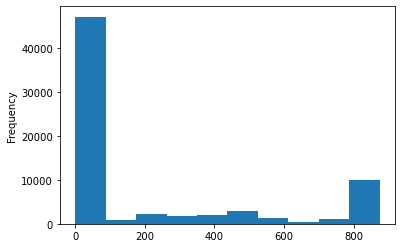

In [17]:
# Check Histogram
train['Existing_EMI'].plot.hist()

#### Tranform One

<AxesSubplot:ylabel='Frequency'>

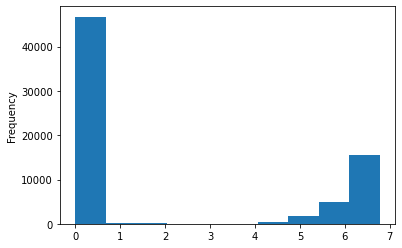

In [18]:
np.log(train['Existing_EMI']+1).plot.hist()

### Do for all

In [19]:
# Import Library
from sklearn.preprocessing import StandardScaler

In [20]:
# Create Instance
num_scaling = StandardScaler()

In [22]:
# Fit
num_scaling.fit(train[numerical_features])

StandardScaler()

In [23]:
# Transform
train[numerical_features] = num_scaling.transform(train[numerical_features])

## 8/ Build Model

## Prepare Data

In [48]:
#create X and y datasets for splitting 
X = train.drop(['ID', 'Approved','DOB', 'Lead_Creation_Date', 'City_Code', 'Employer_Code', 'Customer_Existing_Primary_Bank_Code', 'Source'], axis=1)
y = train['Approved']

## Create Dummy

In [51]:
X = pd.get_dummies(X, drop_first=True)

In [53]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69713 entries, 0 to 69712
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Employer_Category2          69713 non-null  float64
 1   Monthly_Income              69713 non-null  float64
 2   Existing_EMI                69713 non-null  float64
 3   Loan_Amount                 69713 non-null  float64
 4   Loan_Period                 69713 non-null  float64
 5   Interest_Rate               69713 non-null  float64
 6   EMI                         69713 non-null  float64
 7   Var1                        69713 non-null  float64
 8   Gender_Male                 69713 non-null  uint8  
 9   City_Category_B             69713 non-null  uint8  
 10  City_Category_C             69713 non-null  uint8  
 11  City_Category_missing       69713 non-null  uint8  
 12  Employer_Category1_B        69713 non-null  uint8  
 13  Employer_Category1_C        697

## Import LR Package and create Instance

In [49]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter = 1000)

## Build Model

In [54]:
lr.fit(X,y)

LogisticRegression()

### Check Score

In [55]:
lr.score(X, y)

0.9852968599830735